In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import seaborn as siuu
import os

In [60]:
# import zipfile
# paths = [i for i in os.listdir('/home/long/longdata/chúa phù hộ người tên khải/ml med') if i.endswith('.zip')]
# for path_to_zip_file in paths:
# path_to_zip_file = '/content/drive/MyDrive/mitbih_train.csv.zip'
# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#     zip_ref.extractall(path_to_zip_file[:-8])

In [7]:
mitbih_test = pd.read_csv('/content/drive/MyDrive/mitbih_test/mitbih_test.csv')
mitbih_train = pd.read_csv('/content/drive/MyDrive/mitbih_train/mitbih_train.csv')
# ptb_ab = pd.read_csv('/content/drive/MyDrive/ptbdb_abnormal/ptbdb_abnormal.csv')
# ptb_normal = pd.read_csv('/content/drive/MyDrive/ptbdb_normal/ptbdb_normal.csv')

In [8]:
mitbih_test.columns = [str(i) for i in range(1,188)]+ ['class']
mitbih_train.columns = [str(i)  for i in range(1,188)]+ ['class']
# ptb_ab.columns = [str(i)  for i in range(1,188)]+ ['class']
# ptb_normal.columns = [str(i)  for i in range(1,188)]+ ['class']

In [9]:
# full_train = pd.concat([mitbih_train,ptb_ab,ptb_normal], axis = 0)
full_train  = mitbih_train
full_train = full_train.sort_values(by = 'class').reset_index(drop = True)
full_train['class'] = full_train['class'].astype(int)

([], [])

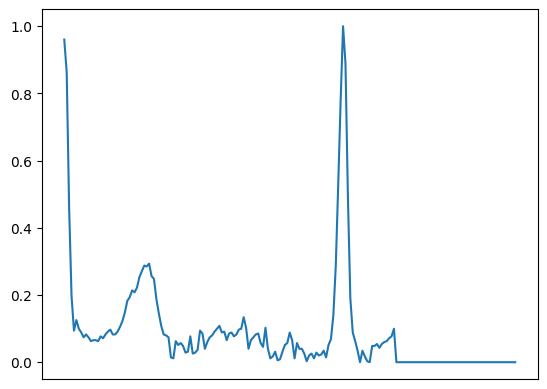

In [29]:
x_values = np.arange(187) * (1000 / 125)
plt.plot(full_train.iloc[0,:-1])
plt.xticks([])

In [10]:
full_train['class'].value_counts()

,count
class,
0,72470
4,6431
2,5788
1,2223
3,641


Text(0.5, 1.0, 'Testing data distribution')

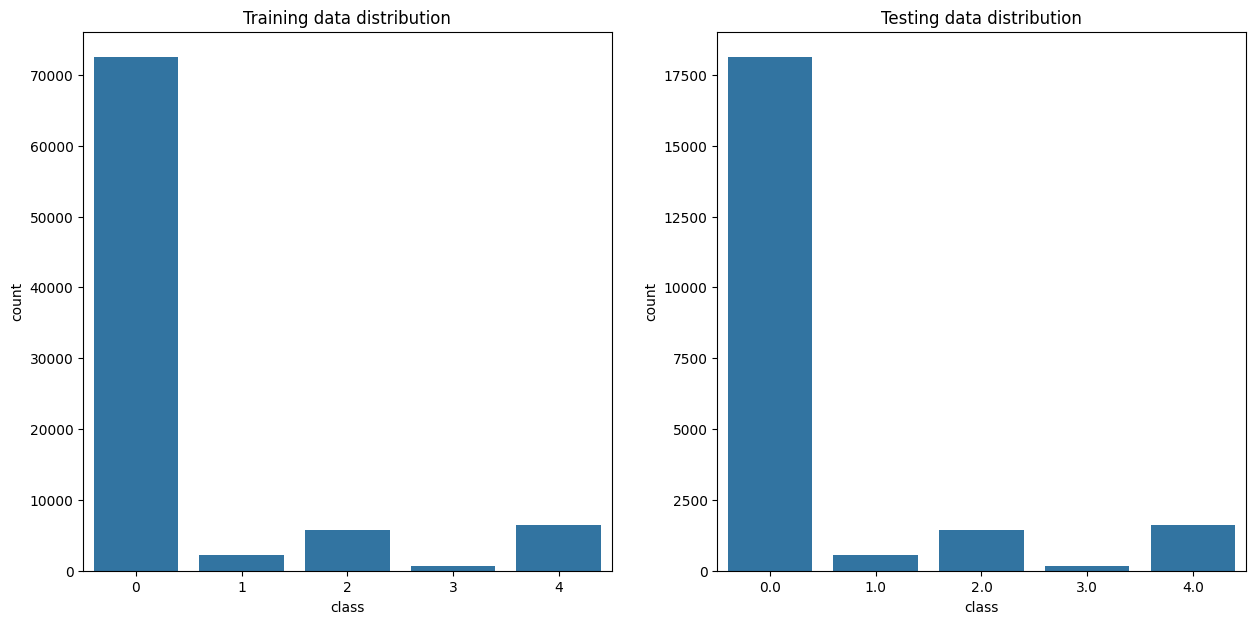

In [65]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
siuu.countplot(data = full_train,x = 'class')
plt.title('Training data distribution')
plt.subplot(1,2,2)
siuu.countplot(data = mitbih_test,x = 'class')
plt.title('Testing data distribution')

In [11]:
label0 = full_train.groupby('class').get_group(0).drop(['class'],axis = 1)
label1 = full_train.groupby('class').get_group(1).drop(['class'],axis = 1)
# label0_sample = label0.sample(6000)


In [13]:
from for_imb_class import get_clustered_data
# for i in range(5):
label_0_cluster = get_clustered_data(label0, 10000)


For n_clusters = 10000 The average silhouette_score is : 0.15333286136546104


For n_clusters = 15000 The average silhouette_score is : 0.1456467419508658
For n_clusters = 10000 The average silhouette_score is : 0.07644702515924003

In [ ]:
label_0_cluster.shape

In [14]:
label_0_cluster_c = pd.DataFrame(label_0_cluster)
label_0_cluster_c['class'] = 0



In [15]:
label3va4va2 =  full_train[(full_train['class'] == 3) | (full_train['class'] == 4)| (full_train['class'] == 1)]
label2  = full_train[(full_train['class'] == 2)]

In [17]:
from imblearn.over_sampling import SMOTE
X = label3va4va2.drop(['class'],axis = 1)
y = label3va4va2['class']
feature, target = SMOTE(sampling_strategy={1:4000,3:2000},k_neighbors=2, random_state=4122004).fit_resample(X, y)
# target = np.array(target).reshape(1,9646)
feature['class'] = target

<ipython-input-17-2a3d970d6a37>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature['class'] = target


In [19]:
feature['class'].value_counts()

,count
class,
4,6431
1,4000
3,2000


In [20]:
train_processed = np.concatenate([label_0_cluster_c.values,label2.values,feature.values],axis = 0)

In [21]:
train_final = pd.DataFrame(train_processed)
train_final.columns = [i for i in range(1,188)] +['class']

In [ ]:
# train_final.to_csv('train_final_tile2.csv')

In [2]:
train_final = pd.read_csv('/content/drive/MyDrive/train_final_tile2.csv',index_col=0)

NameError: name 'pd' is not defined

In [22]:
X = train_final.drop(['class'],axis= 1)
y = train_final['class']
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
X_train, X_val,y_train,y_val = train_test_split(X,y,test_size= 0.19 , stratify = y,random_state=4122004)
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
model = XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric="auc")
model.fit(X_train, y_train)

# Predict
pred = model.predict(X_val)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:58:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


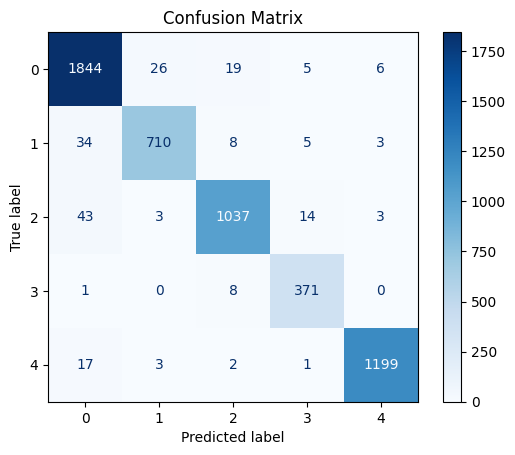

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1900
           1       0.96      0.93      0.95       760
           2       0.97      0.94      0.95      1100
           3       0.94      0.98      0.96       380
           4       0.99      0.98      0.99      1222

    accuracy                           0.96      5362
   macro avg       0.96      0.96      0.96      5362
weighted avg       0.96      0.96      0.96      5362



In [24]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
tate1 = confusion_matrix(y_val, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=tate1)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()
from sklearn.metrics import confusion_matrix, classification_report
target_names = [str(i) for i in range(5)]
print(classification_report(y_val, pred,target_names=target_names))